# Game of Sets - largest card deck with no matches

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Function definitions
- make_card_names
- make_full_deck
- make_third_card
- trim_deck_fast


In [2]:
# make_card_names function initializes card_names df with names and attributes
def make_card_names():
    card_names = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_names['color'] = ['red', 'green', 'purple']
    card_names['shape'] = ['oval', 'diamond', 'squiggle']
    card_names['fill'] = ['solid', 'striped', 'empty']
    card_names['number'] = [1, 2, 3]
    return card_names

In [3]:
# make_full_deck function prepopulates complete card_deck df with all possible combinations using numbers 0, 1, 2 for each of four attributes (n=81)
def make_full_deck():
    card_deck = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    card_deck['color'] = [0] * 27 + [1] * 27 + [2] * 27
    card_deck['shape'] = ([0] * 9 + [1] * 9 + [2] * 9 ) * 3
    card_deck['fill'] =  ([0] * 3 + [1] * 3 + [2] * 3 ) * 9
    card_deck['number'] = [0, 1, 2] * 27
    return card_deck

In [4]:
# test or run make_full_deck function
card_deck = make_full_deck()
len(card_deck)

81

In [5]:
# make_third_card function creates third card to make a set
def make_third_card(card1, card2):
    # Calculate the sum of corresponding elements in card1 and card2, then take the result mod 3
    sum_mod_3 = (card1.values[0] + card2.values[0]) % 3

    # Calculate the third integer 'c' based on the formula: c = 3 - (a + b) mod 3
    c_values = 3 - sum_mod_3
    c_values[c_values == 3] = 0  # Replace 3 with 0, as 3 mod 3 is 0

    # return the resulting dataframe card3
    return pd.DataFrame([c_values], columns=card1.columns)

In [6]:
# trim_deck_fast function selects two random cards, finds the third card that would make a set and drops it from the card_deck if it is present.
# Note that not all matching sets are necessarily removed. Search is random and not exhaustive.
def trim_deck_fast(card_deck, iterations=100):
    for i in range(iterations):
        card1 = card_deck.sample(n=1)
        card2 = card_deck.sample(n=1)
        # make sure card1 and card2 are not the same card
        while card1.equals(card2):
            card2 = card_deck.sample()
        card3 = make_third_card(card1, card2)
        # print('three cards {} {} {}'.format(card1, card2, card3))
        try: 
            i = card_deck[card_deck.eq(card3.squeeze()).all(1)].index
            # if i is not empty, remove the card from the deck
            if i.empty:
                pass
                # print('No set found. Continuing...')
            else:
                # print('Found a set! Removing cards {} {}'.format(i, card_deck.loc[i]))
                card_deck = card_deck.drop(i)
        except KeyError:
            pass
    return card_deck

In [ ]:
# test or run trim_deck_fast function
print(len(card_deck))
card_deck = trim_deck_fast(card_deck, iterations=1000)
len(card_deck)

In [17]:
# make_deck_of_matches function takes a card_deck and returns a deck of all cards that match any pair in the input deck

def make_deck_of_matches(card_deck):
    card_deck_of_matches = pd.DataFrame(columns=['color', 'shape', 'fill', 'number'])
    for i, (index1, _) in enumerate(card_deck.iterrows()):
        card1 = card_deck.loc[[index1]]
        for index2 in list(card_deck.index)[i+1:]:
            card2 = card_deck.loc[[index2]]
            card3 = make_third_card(card1, card2)
            # print(i, index1, card1, "\n")
            # print("index2 = ", index2, "\n card2 = ", card2, "\n")
            # print(card3)
            # card_deck_of_matches = card_deck_of_matches.append(card3) # this is slow
            card_deck_of_matches = pd.concat([card_deck_of_matches, card3], ignore_index=True)
    card_deck_of_matches.reset_index(drop=True, inplace=True)
    return card_deck_of_matches

## Legacy functions

In [8]:
# LEGACY is_set function takes in three cards and returns True if they are a set, False otherwise
def is_set(card1, card2, card3):
    # check if all cards are the same card
    if card1.equals(card2) and card2.equals(card3):
        return False
    # check if any two cards are the same card
    if card1.equals(card2) or card2.equals(card3) or card1.equals(card3):
        return False
    # check if any two cards are not a set
    if (card1['color'] + card2['color'] + card3['color']) % 3 != 0:
        return False
    if (card1['shape'] + card2['shape'] + card3['shape']) % 3 != 0:
        return False
    if (card1['fill'] + card2['fill'] + card3['fill']) % 3 != 0:
        return False
    if (card1['number'] + card2['number'] + card3['number']) % 3 != 0:
        return False
    # if all checks pass, return True
    return True

In [9]:
# LEGACY trim_sets function takes in a card deck and two cards selected by their index and returns a card deck with all cards making a set with those two cards removed
def trim_sets(card_deck, card1_index, card2_index):
    # check that card1_index and card2_index are in range
    if card1_index >= len(card_deck) or card2_index >= len(card_deck):
        print('Error: card index out of range')
        return card_deck
    # initialize empty list to store indices of sets
    sets = []
    # loop through all cards in deck
    for i in range(len(card_deck)):
        # check if cards are a set
        if is_set(card_deck.iloc[card1_index], card_deck.iloc[card2_index], card_deck.iloc[i]):
            # add index of set to sets list
            sets.append(i)
    # drop sets from card deck
    card_deck = card_deck.drop(sets)
    # reset index
    card_deck = card_deck.reset_index(drop=True)
    # return card deck
    return card_deck

In [271]:
# LEGACY trim_deck function takes in a card deck and uses the trim sets function to trim sets from the deck from a random starting point. Matching sets are *not* exhaustively removed.
# iterations defaults to 100, but can be changed to trim more sets
def trim_deck(card_deck, iterations=100):
    for i in range(iterations):
        # pick two random cards from the deck
        card1_index = np.random.randint(len(card_deck))
        card2_index = np.random.randint(len(card_deck))
        # trim card deck of all sets with those two cards
        card_deck = trim_sets(card_deck, card1_index, card2_index)
    return card_deck

## Main program

1. First search for decks with no matches by trimming a full deck of 81 cards. 
1. Confirm that the trimmed deck doesn't contain any matches.
1. Then search for larger decks by adding cards to the trimmed deck.

(array([7.000e+00, 8.700e+01, 3.510e+02, 1.035e+03, 2.127e+03, 2.987e+03,
        2.952e+03, 4.250e+02, 2.800e+01, 1.000e+00]),
 array([ 9. ,  9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18. ]),
 <BarContainer object of 10 artists>)

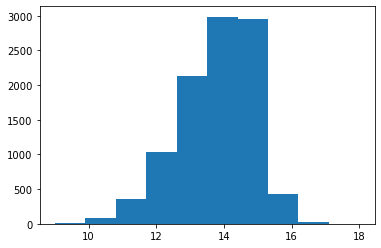

In [208]:
# trim a bunch of full card_decks and record the final lengths and resulting deck
trimmed_decks = []
trimmed_deck_lengths = []
for i in range(10000):
    # make a new deck
    card_deck = make_full_deck()
    # trim the deck
    card_deck = trim_deck_fast(card_deck, 200)
    # run again if length is more than 15, then 16
    if len(card_deck) > 15:
        card_deck = trim_deck_fast(card_deck, 1000)
    if len(card_deck) > 16:
        card_deck = trim_deck_fast(card_deck, 5000)
    # add the deck to the list of trimmed decks
    trimmed_decks.append(card_deck)
    # add the length of the deck to the list of trimmed deck lengths
    trimmed_deck_lengths.append(len(card_deck))

# plot the distribution of trimmed deck lengths
plt.hist(trimmed_deck_lengths)

In [ ]:
# count the number of times each deck length appears and sort the output
trimmed_deck_lengths = pd.Series(trimmed_deck_lengths)
trimmed_deck_lengths.value_counts().sort_index()


In [210]:
long_decks = []
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        long_decks.append(trimmed_decks[i])
len(long_decks)

29

In [ ]:
# loop through long_decks and apply trim_deck function to each deck
for i in range(len(long_decks)):
    long_decks[i] = trim_deck_fast(long_decks[i], 5000)

# print the length of each deck
for i in range(len(long_decks)):
    print(len(long_decks[i]))

In [214]:
# loop through long_decks and save each deck to a csv file
for i in range(len(long_decks)):
    long_decks[i].to_csv('trimmed_deck_b' + str(i) + '.csv', index=True)


In [ ]:
# print the decks from trimmed_decks with the longest length
for i in range(len(trimmed_decks)):
    if len(trimmed_decks[i]) > 16:
        print(i, trimmed_decks[i])

## test and explore making decks of matches

In [9]:
test_deck = card_deck.iloc[[0, 4, 6, 10, 11]]
test_deck

,color,shape,fill,number
0,0,0,0,0
4,0,0,1,1
6,0,0,2,0
10,0,1,0,1
11,0,1,0,2


In [10]:
test_deck_of_matches = make_deck_of_matches(test_deck)
duplicate_rows = test_deck_of_matches[test_deck_of_matches.duplicated()]

print("duplicate rows: ", duplicate_rows)
test_deck_of_matches

duplicate rows:  Empty DataFrame
Columns: [index, color, shape, fill, number]
Index: []


,index,color,shape,fill,number
0,0,0,0,2,2
1,1,0,0,1,0
2,2,0,2,0,2
3,3,0,2,0,1
4,4,0,0,0,2
5,5,0,2,2,1
6,6,0,2,2,0
7,7,0,2,1,2
8,8,0,2,1,1
9,9,0,1,0,0


In [15]:
# Import a saved trimmed deck
trimmed_deck_0 = pd.read_csv('trimmed_deck_0.csv', index_col=False)
trimmed_deck_0 = trimmed_deck_0.reset_index(drop=True)
print("length = ", len(trimmed_deck_0))
print("duplicate rows: ", trimmed_deck_0[trimmed_deck_0.duplicated()])
trimmed_deck_0


length =  17
duplicate rows:  Empty DataFrame
Columns: [color, shape, fill, number]
Index: []


,color,shape,fill,number
0,0,0,0,0
1,0,0,1,2
2,0,0,2,2
3,0,2,1,1
4,0,2,2,0
5,0,2,2,1
6,1,0,0,1
7,1,0,1,2
8,1,0,2,1
9,1,1,1,0


In [19]:
match_deck_0 = make_deck_of_matches(trimmed_deck_0)
print("length = ", len(match_deck_0))
print("duplicate rows: ", match_deck_0[match_deck_0.duplicated()])
match_deck_0 = match_deck_0.drop_duplicates()
print("length = ", len(match_deck_0))
print("duplicate rows: ", match_deck_0[match_deck_0.duplicated()])
match_deck_0

length =  136
duplicate rows:      color shape fill number
17      0     1    1      0
21      2     0    1      2
30      1     1    0      0
31      0     1    0      0
35      2     0    0      2
..    ...   ...  ...    ...
131     2     0    2      1
132     2     0    1      0
133     2     2    2      0
134     2     2    1      2
135     2     2    0      2

[72 rows x 4 columns]
length =  64
duplicate rows:  Empty DataFrame
Columns: [color, shape, fill, number]
Index: []


,color,shape,fill,number
0,0,0,2,1
1,0,0,1,1
2,0,1,2,2
3,0,1,1,0
4,0,1,1,2
...,...,...,...,...
104,0,2,1,0
109,0,2,1,2
126,2,2,1,2
129,2,1,2,0


In [26]:
common_rows = trimmed_deck_0.merge(match_deck_0)
print(common_rows)


Empty DataFrame
Columns: [color, shape, fill, number]
Index: []


In [25]:
 (match_deck_0).isin(trimmed_deck_0).all(axis=1).any()

False

In [22]:
len(trimmed_deck_0)

17

In [29]:
trimmed_deck = trimmed_deck_0

# Step 1: Create the match_deck
match_deck = make_deck_of_matches(trimmed_deck)

# Step 2: Check for duplicates
trimmed_deck_duplicates = trimmed_deck[trimmed_deck.duplicated()]
match_deck_duplicates = match_deck[match_deck.duplicated()]

full_deck = make_full_deck()
# unique_rows = full_deck[~full_deck.isin(trimmed_deck.append(match_deck))]

# Step 3: Find unique rows
combined_deck = pd.concat([trimmed_deck, match_deck]).drop_duplicates()
# unused_cards = full_deck[~full_deck.isin(combined_deck).all(axis=1)]
unused_cards = full_deck[~full_deck.apply(tuple, axis=1).isin(combined_deck.apply(tuple, axis=1))]


# Step 4: Print out lengths
print("Length of trimmed_deck: ", len(trimmed_deck))
print("Length of match_deck: ", len(match_deck))
print("Length of unique_rows: ", len(unused_cards))

Length of trimmed_deck:  17
Length of match_deck:  136
Length of unique_rows:  0
